In [1]:
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import h5py
import os
from fooof import FOOOF

TRIAL_NAME = "baseline1"
RESULT_PATH = "simulation_results"
TRIAL_PATH = os.path.join(RESULT_PATH, TRIAL_NAME)

ecp_file = "ecp.h5"
with h5py.File(os.path.join(TRIAL_PATH, ecp_file), 'r') as f:
    lfp = f['ecp']['data'][:, 0]
    lfp -= np.mean(lfp)
    t = np.arange(*f['ecp']['time'])
    fs = 1000 / f['ecp']['time'][2] # sampling rate Hz

In [2]:
period = 1.5 # stimulus period (second)
ncycle = int(np.ceil(t[-1] / period / 1000))
npercyc = int(period * fs)
ton = [0.0, 1.0] # stimulus 'on' time (second) per cycle
non = np.clip((np.array(ton) * fs).astype(int), 0, npercyc)

tseg = .25 # time segment length for PSD (second)
nfft = int(tseg * fs)
nsegpercycle =  np.ceil((non[1] - non[0]) / nfft).astype(int)
lfp_on = np.zeros(ncycle * nsegpercycle * nfft)
for i in range(ncycle):
    for j in range(nsegpercycle):
        k = i * nsegpercycle + j
        x = lfp[i*npercyc + non[0]+j*nfft : i*npercyc + min(non[0]+(j+1)*nfft, non[1])]
        lfp_on[k*nfft : k*nfft + x.size] = x
f, pxx = ss.periodogram(lfp_on, fs=fs, nfft=nfft)

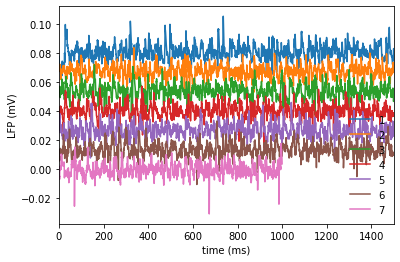

In [3]:
dv = 3 * np.std(lfp)
plt.figure()
for i in range(ncycle):
    x = lfp[i*npercyc:(i+1)*npercyc] + (ncycle - i - 1) * dv
    plt.plot(t[:x.size], x, label=str(i + 1))
plt.xlim([0, period * 1000])
plt.xlabel('time (ms)')
plt.ylabel('LFP (mV)')
plt.legend(loc='lower right', frameon=False)
plt.show()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 8 - 500 Hz                        
                                 Frequency Resolution is 4.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -2.8594, 2394.7861, 2.3564                                    
                                                                                                  
                                       6 peaks were found:                                        
          

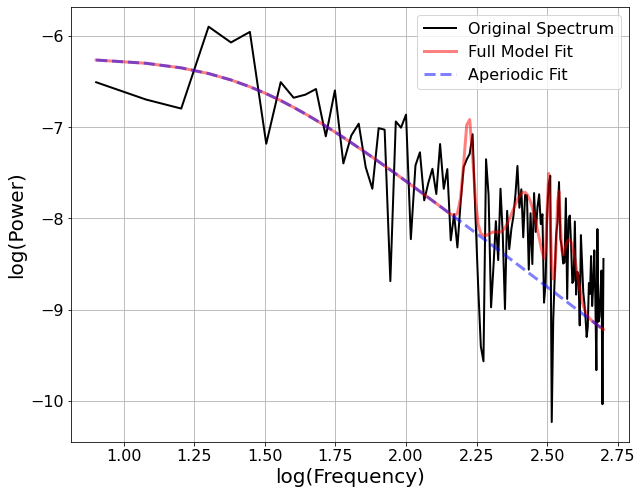

In [4]:
freq_range = [f[2], 500]
peak_width_limits = [f[2], 100]
dB_threshold = 3. # decibel
# Initialize a FOOOF object
fm = FOOOF(peak_width_limits=peak_width_limits, min_peak_height=dB_threshold/10,
           peak_threshold=0.0, max_n_peaks=6, aperiodic_mode='knee')

# Alternatively, just fit the model with FOOOF.fit() (without printing anything)
fm.fit(f, pxx, freq_range)
results = fm.get_results()

# After fitting, plotting and parameter fitting can be called independently:
fm.print_results()
fm.plot(plt_log=True)

In [5]:
print('Knee location: %.2f Hz' % results.aperiodic_params[1]**(1/results.aperiodic_params[2]))

Knee location: 27.17 Hz


In [6]:
SAVE_PATH = os.path.join(TRIAL_PATH, 'FOOOF_results')
fm.save(SAVE_PATH, save_results=True, save_settings=True, save_data=True)

# Save out a report of the current model fit & results
REPORT_PATH = os.path.join(TRIAL_PATH, 'FOOOF_report')
# fm.save_report(REPORT_PATH, plt_log=True)

plotting spike raster


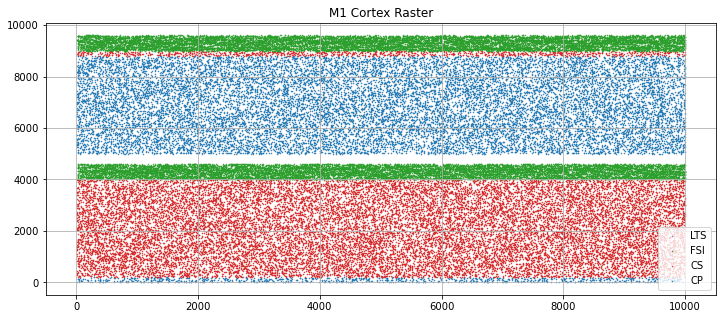

plotting firing rates
Type : mean (std)
CP : 1.21 (0.61)
CS : 1.42 (0.66)
FSI : 5.08 (4.02)
LTS : nan (nan)
Type : mean (std)
CP : 1.21 (0.61)
CS : 1.42 (0.66)
FSI : 5.08 (4.02)
LTS : nan (nan)


E:\Users\lenovo\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
E:\Users\lenovo\anaconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


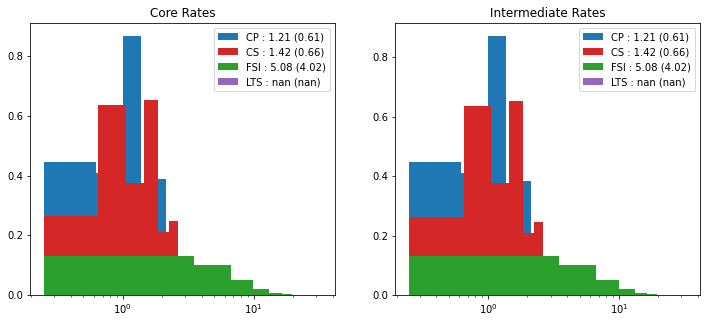

In [7]:
MODEL_PATH = '../M1Focus/'
import sys
sys.path.append(MODEL_PATH)
import plot
%matplotlib inline

spike_file = os.path.join('..','Analysis',TRIAL_PATH,'spikes.h5')
config_file = os.path.join(MODEL_PATH,'config.json')
plot.plot(choose=1, file=spike_file, config=config_file, figsize=(12,5))
spikes_df = plot.plot(choose=2, file=spike_file, figsize=(12,5))